In [1]:
import os

DATA_DIR = 'simp_gans_data'
print(os.listdir(DATA_DIR))

['images']


In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

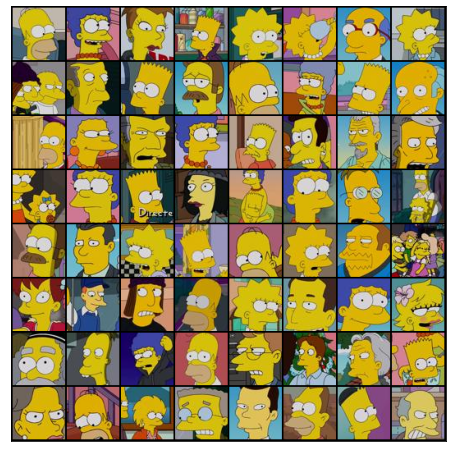

In [8]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
import torch.nn as nn

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


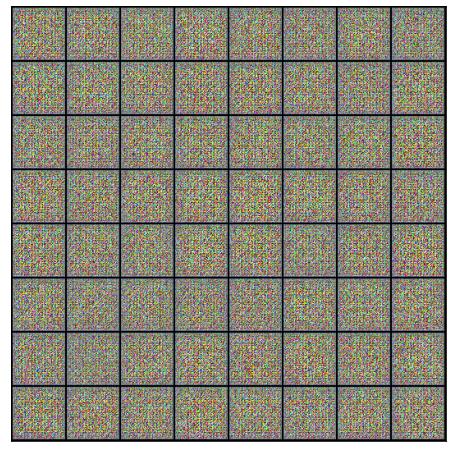

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [21]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [22]:
from torchvision.utils import save_image

In [23]:
sample_dir = 'simp_generation_1'
os.makedirs(sample_dir, exist_ok=True)


In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'simp-img-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [25]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving simp-img-0000.png


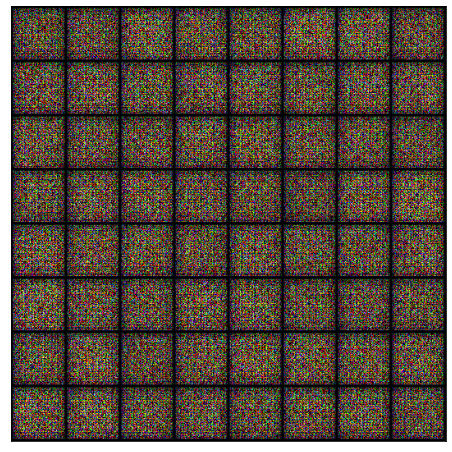

In [26]:
save_samples(0, fixed_latent)

In [27]:

import torch.nn.functional as F

In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in (train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 300

In [30]:
history = fit(epochs, lr,start_idx=1)

Epoch [1/300], loss_g: 6.2040, loss_d: 0.1574, real_score: 0.9033, fake_score: 0.0480
Saving simp-img-0001.png
Epoch [2/300], loss_g: 6.2165, loss_d: 0.6644, real_score: 0.9059, fake_score: 0.3993
Saving simp-img-0002.png
Epoch [3/300], loss_g: 1.6813, loss_d: 0.5344, real_score: 0.7003, fake_score: 0.1242
Saving simp-img-0003.png
Epoch [4/300], loss_g: 1.6257, loss_d: 0.8260, real_score: 0.5791, fake_score: 0.0810
Saving simp-img-0004.png
Epoch [5/300], loss_g: 5.5753, loss_d: 0.4825, real_score: 0.8558, fake_score: 0.2483
Saving simp-img-0005.png
Epoch [6/300], loss_g: 2.8491, loss_d: 0.5137, real_score: 0.7755, fake_score: 0.2030
Saving simp-img-0006.png
Epoch [7/300], loss_g: 0.8112, loss_d: 1.1812, real_score: 0.3844, fake_score: 0.0771
Saving simp-img-0007.png
Epoch [8/300], loss_g: 5.6705, loss_d: 1.1274, real_score: 0.9434, fake_score: 0.6046
Saving simp-img-0008.png
Epoch [9/300], loss_g: 2.1885, loss_d: 0.4847, real_score: 0.7663, fake_score: 0.1703
Saving simp-img-0009.png
E

KeyboardInterrupt: 

In [31]:
torch.save(generator.state_dict(), 'G_simpsons.pth')
torch.save(discriminator.state_dict(), 'D_simpsons.pth')

In [1]:
import cv2
import os

vid_fname = 'simpsons_gans.mp4'
frame = cv2.imread("simp_generation_1/simp-img-0000.png")
height, width, layers = frame.shape


#insering frames into video
video = cv2.VideoWriter("./simp_gan.avi", 0,10, (width, height)) 
files = os.listdir("simp_generation_1")
files.sort()
for i in files: 
   video.write(cv2.imread("simp_generation_1/"+i)) 
   print(i)

simp-img-0000.png
simp-img-0001.png
simp-img-0002.png
simp-img-0003.png
simp-img-0004.png
simp-img-0005.png
simp-img-0006.png
simp-img-0007.png
simp-img-0008.png
simp-img-0009.png
simp-img-0010.png
simp-img-0011.png
simp-img-0012.png
simp-img-0013.png
simp-img-0014.png
simp-img-0015.png
simp-img-0016.png
simp-img-0017.png
simp-img-0018.png
simp-img-0019.png
simp-img-0020.png
simp-img-0021.png
simp-img-0022.png
simp-img-0023.png
simp-img-0024.png
simp-img-0025.png
simp-img-0026.png
simp-img-0027.png
simp-img-0028.png
simp-img-0029.png
simp-img-0030.png
simp-img-0031.png
simp-img-0032.png
simp-img-0033.png
simp-img-0034.png
simp-img-0035.png
simp-img-0036.png
simp-img-0037.png
simp-img-0038.png
simp-img-0039.png
simp-img-0040.png
simp-img-0041.png
simp-img-0042.png
simp-img-0043.png
simp-img-0044.png
simp-img-0045.png
simp-img-0046.png
simp-img-0047.png
simp-img-0048.png
simp-img-0049.png
simp-img-0050.png
simp-img-0051.png
simp-img-0052.png
simp-img-0053.png
simp-img-0054.png
simp-img-0

In [40]:
print(os.listdir("simp_generation_1"))

['simp-img-0023.png', 'simp-img-0045.png', 'simp-img-0082.png', 'simp-img-0013.png', 'simp-img-0100.png', 'simp-img-0177.png', 'simp-img-0049.png', 'simp-img-0004.png', 'simp-img-0083.png', 'simp-img-0062.png', 'simp-img-0137.png', 'simp-img-0197.png', 'simp-img-0148.png', 'simp-img-0180.png', 'simp-img-0090.png', 'simp-img-0088.png', 'simp-img-0154.png', 'simp-img-0069.png', 'simp-img-0187.png', 'simp-img-0149.png', 'simp-img-0020.png', 'simp-img-0162.png', 'simp-img-0074.png', 'simp-img-0097.png', 'simp-img-0005.png', 'simp-img-0038.png', 'simp-img-0140.png', 'simp-img-0000.png', 'simp-img-0067.png', 'simp-img-0163.png', 'simp-img-0022.png', 'simp-img-0092.png', 'simp-img-0103.png', 'simp-img-0129.png', 'simp-img-0007.png', 'simp-img-0118.png', 'simp-img-0125.png', 'simp-img-0101.png', 'simp-img-0059.png', 'simp-img-0077.png', 'simp-img-0102.png', 'simp-img-0168.png', 'simp-img-0182.png', 'simp-img-0186.png', 'simp-img-0190.png', 'simp-img-0184.png', 'simp-img-0157.png', 'simp-img-00